# Imports

In [17]:
import MySQLdb
from pymongo import MongoClient
import pandas
import numpy as np
import json
import time
import matplotlib.pyplot as plt

# Conexão com a base no MongoDB

In [18]:
# Conexão com o MongoDB
client = MongoClient()
client = MongoClient('localhost', 27017)
# Cria uma base de dados no MongoDB
db_mongo = client['tf_f_dupla1_fim']

# Conexão com a base no MySQL

In [19]:
# Conexão com o MySQL
db = MySQLdb.connect("localhost","root","Lucas1@2","tf_f_dupla1_fim")
cursor = db.cursor()

# Configurações da base no MySQL
db.set_character_set('utf8')
cursor.execute('SET NAMES utf8;')
cursor.execute('SET CHARACTER SET utf8;')
cursor.execute('SET character_set_connection=utf8;')

0

# Classe para ler e salvar os 'Ratings' nas bases

In [20]:
class ReadRating():
    def __init__(self, path):
        self.data = None
        self.data2 = None
        #self.data3 = None
        self.movies = None
        self.json_data = None
        self.path = path
        self.insert = """INSERT INTO RATING (user, idMovie, rating) VALUES (%s, %s, %s)"""
        
        self.read_data()
    def read_data(self):
        self.data = pandas.read_csv(self.path,
                        usecols=['movieId', 'rating', 'userId']) # , 'timestamp'
        self.data = self.data.dropna()
        self.data = self.data.sample(n=3000000)
        
        self.data2 = pandas.read_csv('./movies_metadata.csv', usecols=['id'])
        self.data2 = self.data2.rename(columns = {'id': 'movieId'})
        self.data2.drop_duplicates(subset ='movieId', keep = 'first', inplace = True)
        
        self.data['movieId']=self.data['movieId'].astype(str)
        self.data2['movieId']=self.data2['movieId'].astype(str)

        self.data = self.data.merge(self.data2, on='movieId', how='inner')
        self.data = self.data.sample(n=1000000)

        self.json_data = self.data.to_json(orient = "records")

    def save_data(self):
        aux = 0
        dataframe = self.data.values.tolist()

        cursor.executemany(self.insert, dataframe)
        db.commit()


    def save_mongo(self):
        json_ratings = json.loads(self.json_data)

        # Cria uma coleção
        
        ratings = db_mongo['rating']
        ratings.insert_many(json_ratings)

# Função principal

In [21]:
def main():
    database_save = ReadRating('./ratings.csv')
    database_save.save_data()
    database_save.save_mongo()
    db.close()

In [22]:
main()

# Gráficos

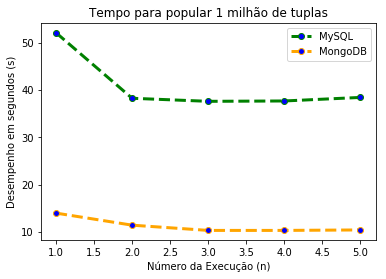

In [16]:
mysql = [52.13107109069824, 38.26264238357544, 37.615535736083984, 37.69218707084656, 38.44320297241211]
mongo = [13.959964752197266, 11.40522575378418, 10.29539155960083, 10.296449184417725, 10.397173404693604]
ages = [1, 2, 3, 4, 5]

plt.plot(ages, mysql, linestyle='dashed', color='g', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=6, label = "MySQL")
plt.plot(ages, mongo, linestyle='dashed', color='orange', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=6, label = "MongoDB")
plt.xlabel('Número da Execução (n)')
plt.ylabel('Desempenho em segundos (s)')
plt.title('Tempo para popular 1 milhão de tuplas')
plt.legend()
plt.savefig('populate.png')
plt.show()

# Desempenho em deletar dados

In [8]:
print('Tamanho da base: ', db_mongo['rating'].count_documents({}), 'documentos\n')

# Computa o tempo para excluir as tuplas de rating
start_time = time.time()
db_mongo['rating'].remove({})
end_time = time.time()

# Tempo para excluir 1 milhão de tuplas
print('Tempo em segundos (MongoDB): ', end_time-start_time, '\n')

Tamanho da base:  1000000 documentos



/home/regis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  """


Tempo em segundos (MongoDB):  6.839916229248047 



In [15]:
cursor.execute('SELECT COUNT(*) FROM RATING;')
ratings = cursor.fetchall()
print('Tamanho da base: ', *ratings, 'tuplas\n')

# Computa o tempo para excluir as tuplas de rating
start_time = time.time()
cursor.execute("DELETE FROM RATING;")
end_time = time.time()

# Tempo para excluir 1 milhão de tuplas
print('Tempo em segundos (MySQL): ', end_time-start_time, '\n')

Tamanho da base:  (1000000,) tuplas

Tempo em segundos (MySQL):  32.65891408920288 

